# Europe PMC data citations for ACRL 2025

Use citations (annotations) from Europe PMC, and bring in data from multiple other data sources

Note: this notebook uses previously prepared data in files that are not checked into version control

In [1]:
import sys

In [2]:
sys.path.append("..")

In [3]:
from clean_doi import clean_doi, NoDoiException

def is_it_a_doi(doi: str) -> bool:
    # if clean_doi is unsuccessful, return False indicating that the input was not actually a doi
    try:
        cleaned_doi = clean_doi(doi)
        return True
    except NoDoiException:
        return False

In [4]:
import pandas as pd
import numpy as np

In [5]:
from openalex_utils import get_openalex_dataframe_from_multiple_works_files, get_ror_map_from_institutions_file

### OpenAlex data

OpenAlex was used to collect DOIs for Northwestern University and University of Colorado, Boulder for the years 2013-2024.

In [6]:
ror_map = get_ror_map_from_institutions_file("../data/openalex_data_20250130/openalex_institutions.gz")
df_openalex = get_openalex_dataframe_from_multiple_works_files("../data/poster_acrl2025/openalex_data_20250205/", ror_map=ror_map)
df_openalex = df_openalex.drop_duplicates(subset=["doi"])

In [7]:
ucboulder_openalex_id = "I188538660"
northwestern_openalex_id = "I111979921"
df_openalex["affil_ucboulder"] = df_openalex["lineage"].apply(lambda institutions: ucboulder_openalex_id in institutions)
df_openalex["affil_northwestern"] = df_openalex["lineage"].apply(lambda institutions: northwestern_openalex_id in institutions)

In [8]:
df_openalex["type"].value_counts()

type
article                    141630
review                      10797
book-chapter                 9034
preprint                     8827
letter                       4124
dataset                      2396
peer-review                  1413
editorial                    1399
report                        896
other                         856
erratum                       812
paratext                      577
book                          549
reference-entry                25
retraction                     13
dissertation                   12
supplementary-materials         4
Name: count, dtype: int64

In [9]:
df_openalex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183364 entries, W3103145119 to W4398970660
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   doi                 183364 non-null  object
 1   pmid                82264 non-null   object
 2   pmcid               31127 non-null   object
 3   publication_date    183364 non-null  object
 4   is_oa               183364 non-null  bool  
 5   oa_url              113319 non-null  object
 6   type                183364 non-null  object
 7   type_crossref       183364 non-null  object
 8   institutions        183364 non-null  object
 9   institutions_ror    183364 non-null  object
 10  lineage             183364 non-null  object
 11  funders             183364 non-null  object
 12  datasets            183364 non-null  object
 13  cited_by_count      183364 non-null  int64 
 14  primary_topic       181023 non-null  object
 15  topic_subfield      181023 non-null  obje

In [12]:
num_unique_dois_northwestern = df_openalex[df_openalex["affil_northwestern"]==True]["doi"].nunique()
print(f"Number of unique DOIs affiliated with Northwestern University: {num_unique_dois_northwestern:,}")
num_unique_dois_ucboulder = df_openalex[df_openalex["affil_ucboulder"]==True]["doi"].nunique()
print(f"Number of unique DOIs affiliated with University of Colorado Boulder: {num_unique_dois_ucboulder:,}")


Number of unique DOIs affiliated with Northwestern University: 113,608
Number of unique DOIs affiliated with University of Colorado Boulder: 70,388


In [20]:
df_openalex["publication_date"] = pd.to_datetime(df_openalex["publication_date"])
counts_by_year = df_openalex.groupby(df_openalex["publication_date"].dt.year)[["affil_ucboulder", "affil_northwestern"]].sum().sort_index()
counts_by_year.to_csv("../data/poster_acrl2025/openalex_counts_by_year_ucboulder_and_northwestern.csv")


### Europe PMC citations

Combine the OpenAlex data with Europe PMC

In [8]:
df_doi_accession_europepmc = pd.read_parquet('../data/europepmc/df_doi_accession_europepmc.parquet').dropna(subset=["DOI"])

In [9]:
oax_fields_to_merge = [
    "publication_date",
    "is_oa",
    "type",
    "type_crossref",
    "institutions_ror",
    "primary_topic",
    "topic_subfield",
    "topic_field",
    "topic_domain",
    "funders",
    "datasets",
    "affil_ucboulder",
    "affil_northwestern",
]
to_merge = df_openalex.rename(columns={"doi": "DOI"})[["DOI"] + oax_fields_to_merge].reset_index()
df_accession_match = df_doi_accession_europepmc.merge(to_merge, how="inner", on="DOI")

### Data Citation Corpus

Bring in Corpus data

In [10]:
df_corpus = pd.read_parquet('../data/df_2024-08-23-data-citation-corpus-v2.0.parquet')

In [11]:
# identify matches in Corpus
df_accession_match["target_upper"] = df_accession_match["accession_number"].str.upper()
to_merge = df_corpus.reset_index(names="corpus_id")
to_merge["corpus_has_affils"] = to_merge["affiliations"].apply(lambda x: len(x) > 0)
to_merge["target_upper"] = to_merge["dataset"].str.upper()
to_merge = to_merge.rename(columns={"publication": "DOI"})
to_merge = to_merge.rename(columns={"funders": "cited_funders", "subjects": "cited_subjects"})
to_merge = to_merge[["DOI", "target_upper", "corpus_id", "corpus_has_affils", "cited_funders", "cited_subjects"]]
df_accession_match = df_accession_match.merge(to_merge, how="left", on=["DOI", "target_upper"])

In [12]:
cols_rename = {
    "accession_number": "target",
    "repository_europepmc": "cited_repository",
    "DOI": "citing_doi",
    "openalex_id": "citing_openalex_id",
    "is_oa": "citing_is_oa",
    "type": "citing_openalex_type",
    "institutions_ror": "citing_institutions_ror",
    "primary_topic": "citing_primary_topic",
    "topic_subfield": "citing_topic_subfield",
    "topic_field": "citing_topic_field",
    "topic_domain": "citing_topic_domain",
    "funders": "citing_openalex_funders",
    "datasets": "citing_openalex_datasets",
}
df_accession_match = df_accession_match.rename(columns=cols_rename)

In [13]:
df_accession_match["publication_date"] = pd.to_datetime(df_accession_match["publication_date"])
df_accession_match["publication_year"] = df_accession_match["publication_date"].dt.year

In [14]:
df_accession_match["cited_is_doi"] = df_accession_match["target"].apply(is_it_a_doi)

### DOI Metadata

Data for target DOIs was pulled from the DataCite and Crossref APIs

In [15]:
df_datacite_and_crossref_metadata = pd.read_csv("../data/poster_acrl2025/df_datacite_and_crossref_metadata.csv")

In [16]:
# new column for cited title from DataCite or Crossref API
title_map = df_datacite_and_crossref_metadata.set_index("doi", verify_integrity=True)["title"]
df_accession_match["cited_title"] = df_accession_match["target"].map(title_map)

In [17]:
# new column for whether the DataCite or Crossref API has any affiliation info
has_affil_map = df_datacite_and_crossref_metadata.set_index("doi", verify_integrity=True)["has_affiliation_data"]
df_accession_match["doi_api_has_affils"] = df_accession_match["target"].map(has_affil_map)

In [18]:
# update repository information for cited DOIs (leave accession numbers alone)
df_accession_match["cited_repository"] = df_accession_match["cited_repository"].astype(str).replace("doi", np.nan)
repo_map = df_datacite_and_crossref_metadata.set_index("doi", verify_integrity=True)["repository"]
update_repo = df_accession_match["target"].map(repo_map)
df_accession_match["cited_repository"] = df_accession_match["cited_repository"].combine_first(update_repo)

In [19]:
# update missing subjects with info from DataCite or Crossref API
df_accession_match["cited_subjects"] = df_accession_match["cited_subjects"].apply(lambda x: np.nan if str(x) == '[]' else x)
subj_map = df_datacite_and_crossref_metadata.set_index("doi", verify_integrity=True)["subjects"]
update_subjs = df_accession_match["target"].map(subj_map)
df_accession_match["cited_subjects"] = df_accession_match["cited_subjects"].combine_first(update_subjs)

In [20]:
# update missing funders with info from DataCite or Crossref API
df_accession_match["cited_funders"] = df_accession_match["cited_funders"].apply(lambda x: np.nan if str(x) == '[]' else x)
fund_map = df_datacite_and_crossref_metadata.set_index("doi", verify_integrity=True)["funders"]
update_funders = df_accession_match["target"].map(fund_map)
df_accession_match["cited_funders"] = df_accession_match["cited_funders"].combine_first(update_funders)

In [21]:
# rearrange columns
columns = """
        target
        PMCID
        EXTID
        SOURCE
        cited_repository
        cited_is_doi
        citing_doi
        cited_subjects
        cited_funders
        cited_title
        citing_openalex_id
        citing_is_oa
        citing_openalex_type
        citing_institutions_ror
        citing_primary_topic
        citing_topic_subfield
        citing_topic_field
        citing_topic_domain
        citing_openalex_funders
        citing_openalex_datasets
        affil_ucboulder
        affil_northwestern
        target_upper
        corpus_id
        corpus_has_affils
        doi_api_has_affils
        publication_year
""".split()
df_accession_match = df_accession_match[columns]

### Bring in manual mapping of repository -> subjects

In [22]:
# bring in repository-based subject (discipline) info
# from https://docs.google.com/spreadsheets/d/1TddyO5We5mJidWBC_FTiZY0kpvJXutHJMqKv1sLK82c/edit?gid=2047674143#gid=2047674143
df_repo_subj = pd.read_csv("../data/poster_acrl2025/assertion-count-by-repo - accession-numbers-only.csv", usecols=["title", "abbreviation", "FOS mapping by DataCite staff"])
df_repo_subj = df_repo_subj.rename(columns={"FOS mapping by DataCite staff": "subjects"})
df_repo_subj = df_repo_subj.dropna()
df_repo_subj["abbreviation"] = df_repo_subj["abbreviation"].str.strip()
df_repo_subj = df_repo_subj[~(df_repo_subj["subjects"].str.contains("omit from v2"))]

In [23]:
# Some repo abbrevs are misaligned between the Europe PMC data and DataCite
# Map DataCite abbreviations to Europe PMC abbreviations
abbrevs_map = {
    "dbsnp": "refsnp",
    "ena.embl": "gen",
    "GO": "go",
    "insdc.gca": "gca",
    "pride": "pxd",
    "ega.dataset": "ega",
    "biomodels.db": "biomodels",
}

In [24]:
repos_mapped = df_repo_subj["abbreviation"].map(lambda x: abbrevs_map.get(x, x))
repo_subj_map = df_repo_subj.set_index(repos_mapped, verify_integrity=True)["subjects"]
repo_subj_map = repo_subj_map.apply(lambda x: x.split("; "))


In [25]:
update_subjs = df_accession_match["cited_repository"].map(repo_subj_map)
df_accession_match["cited_subjects"] = df_accession_match["cited_subjects"].apply(lambda x: np.nan if str(x) == '[]' else x)
df_accession_match["cited_subjects"] = df_accession_match["cited_subjects"].combine_first(update_subjs)

In [26]:
df_accession_match.to_csv("../data/poster_acrl2025/europepmc_data_citations_northwestern_and_ucboulder.csv", index=False)

* How many data citations for Northwestern University and University of Colorado Boulder
    * Breakdown per DOI and accession number
    * Normalize per article output 

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df_citations_dedup = df_accession_match.drop_duplicates(subset=["target_upper", "citing_doi"])

In [29]:
num_citations_northwestern = int(df_citations_dedup["affil_northwestern"].sum())
num_citations_ucboulder = int(df_citations_dedup["affil_ucboulder"].sum())
df_unique_citing = df_citations_dedup[["citing_doi", "affil_northwestern", "affil_ucboulder"]].drop_duplicates()
num_unique_citing_northwestern = int(df_unique_citing["affil_northwestern"].sum())
num_unique_citing_ucboulder = int(df_unique_citing["affil_ucboulder"].sum())
df_unique_cited = df_citations_dedup[["target_upper", "affil_northwestern", "affil_ucboulder"]].drop_duplicates()
num_unique_cited_northwestern = int(df_unique_cited["affil_northwestern"].sum())
num_unique_cited_ucboulder = int(df_unique_cited["affil_ucboulder"].sum())

print(f"Northwestern has {num_citations_northwestern:,} data citations, with {num_unique_citing_northwestern:,} unique citing publications (DOIs), and {num_unique_cited_northwestern:,} unique cited datasets (DOIs or accession numbers)")
print(f"Univerisity of Colorado Boulder has {num_citations_ucboulder:,} data citations, with {num_unique_citing_ucboulder:,} unique citing publications (DOIs), and {num_unique_cited_ucboulder:,} unique cited datasets (DOIs or accession numbers)")

Northwestern has 32,780 data citations, with 7,193 unique citing publications (DOIs), and 26,865 unique cited datasets (DOIs or accession numbers)
Univerisity of Colorado Boulder has 7,723 data citations, with 1,811 unique citing publications (DOIs), and 6,984 unique cited datasets (DOIs or accession numbers)


* Citation counts per year for each of those two institutions

/tmp/ipykernel_1527/3585058162.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


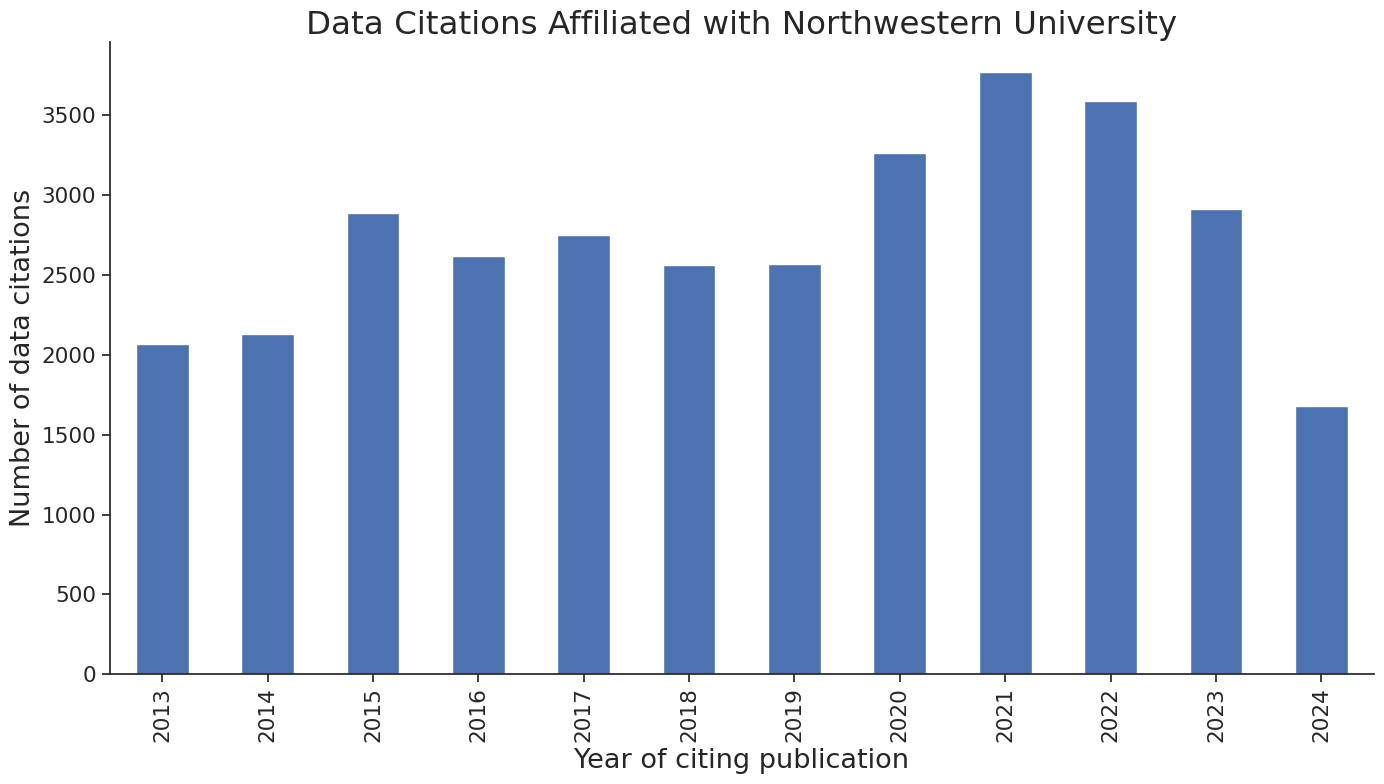

In [30]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 * font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
citations_per_year_northwestern = df_citations_dedup[df_citations_dedup["affil_northwestern"]==True]["publication_year"].value_counts().sort_index()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
# sns.barplot(citations_per_year_northwestern)
citations_per_year_northwestern.plot(kind="bar", ax=ax)
ax.set_title("Data Citations Affiliated with Northwestern University")
ax.set_ylabel("Number of data citations")
ax.set_xlabel("Year of citing publication")
plt.tight_layout()
fig.show()

/tmp/ipykernel_1527/948829173.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


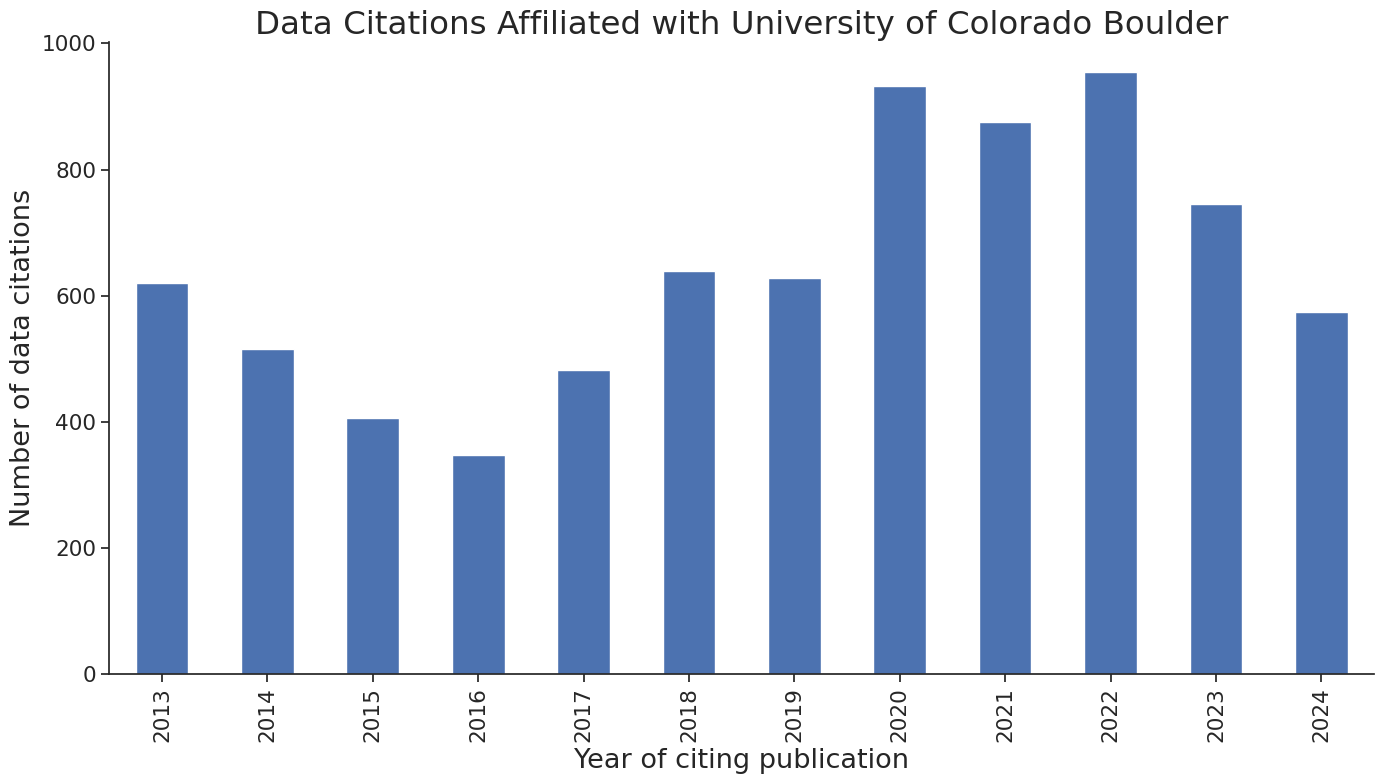

In [31]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 * font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
citations_per_year_ucboulder = df_citations_dedup[df_citations_dedup["affil_ucboulder"]==True]["publication_year"].value_counts().sort_index()
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
# sns.barplot(citations_per_year_ucboulder)
citations_per_year_ucboulder.plot(kind="bar", ax=ax)
ax.set_title("Data Citations Affiliated with University of Colorado Boulder")
ax.set_ylabel("Number of data citations")
ax.set_xlabel("Year of citing publication")
plt.tight_layout()
fig.show()

In [32]:
import json

def _list_interpret(x):
    if type(x) == str:
        try:
            return json.loads(x.replace("'", '"'))
        except json.JSONDecodeError:
            return None
    else:
        return x

def _report_type(x):
    return type(x)

_df = df_citations_dedup.dropna(subset="cited_subjects")
_df["cited_subjects"] = _df["cited_subjects"].apply(_list_interpret)
# _df["subj_type"] = _df["cited_subjects"].apply(_report_type)
# _df["subj_type"].value_counts()
# _df[_df["subj_type"]==str]
_df["cited_subjects"].isna().sum()

/tmp/ipykernel_1527/4005718757.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["cited_subjects"] = _df["cited_subjects"].apply(_list_interpret)


np.int64(6)

In [36]:
cited_subjects = df_citations_dedup[["target_upper", "citing_doi", "cited_subjects", "affil_northwestern", "affil_ucboulder"]].dropna(subset="cited_subjects").explode(column="cited_subjects", ignore_index=True)
cited_subjects

,target_upper,citing_doi,cited_subjects,affil_northwestern,affil_ucboulder
0,E-MTAB-6506,10.1101/2024.07.26.605398,Biological sciences,True,False
1,E-MTAB-6506,10.1101/2024.07.26.605398,Basic medicine,True,False
2,E-MTAB-6508,10.1101/2024.07.26.605398,Biological sciences,True,False
3,E-MTAB-6508,10.1101/2024.07.26.605398,Basic medicine,True,False
4,E-MTAB-6528,10.1101/2024.07.26.605398,Biological sciences,True,False
...,...,...,...,...,...
67888,O13526,10.1021/ja4029654,Basic medicine,True,False
67889,P15381,10.1021/jm4005048,Biological sciences,True,False
67890,P15381,10.1021/jm4005048,Basic medicine,True,False
67891,P49687,10.1371/journal.pbio.1001524,Biological sciences,True,False


In [37]:
vc_subjects = cited_subjects["cited_subjects"].value_counts().reset_index()
vc_subjects

,cited_subjects,count
0,Biological sciences,23213
1,Basic medicine,23213
2,biological sciences,4820
3,basic medicine,4820
4,Chemical sciences,4156
...,...,...
547,"['solar-induced fluorescence', 'GPP', 'needle ...",1
548,sociology,1
549,"['[ 25 ] All Cognitive Disorders/Dementia', '[...",1
550,"['Population ecology', '2012', '2011', 'Entomo...",1


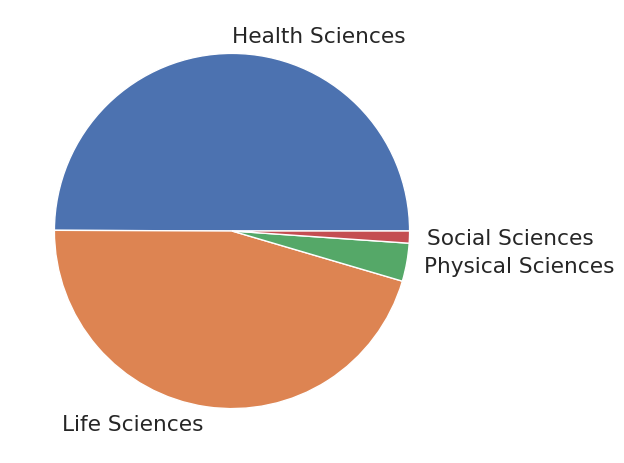

In [38]:
to_plot = df_citations_dedup[df_citations_dedup["affil_northwestern"]==True]["citing_topic_domain"].value_counts()
ax = to_plot.plot(kind="pie")
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

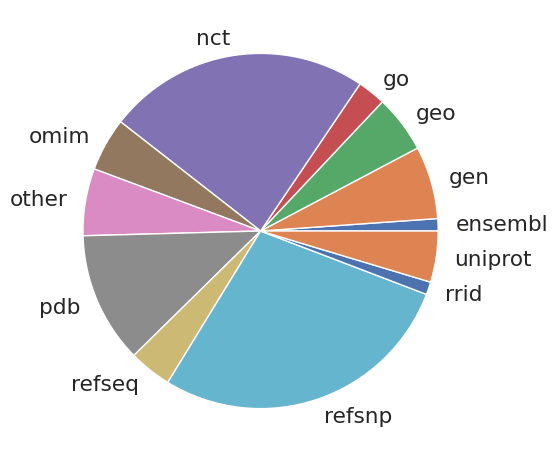

In [39]:
repo_normalize = df_citations_dedup[df_citations_dedup["affil_northwestern"]==True]["cited_repository"].apply(lambda x: x.split(";")[0])
df_repository_counts = repo_normalize.value_counts().reset_index()
# to_plot.loc[to_plot["count"] < 75, "cited_repository"] = "other"
df_repository_counts.loc[df_repository_counts.index > 10, "cited_repository"] = "other"
to_plot = df_repository_counts.groupby("cited_repository").sum("count")
ax = to_plot["count"].plot(kind="pie")
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

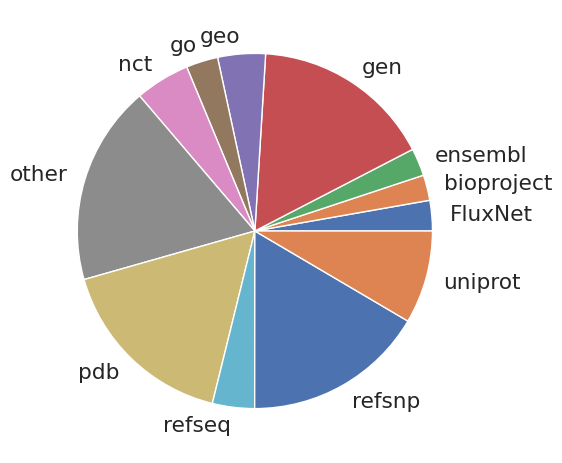

In [41]:
repo_normalize = df_citations_dedup[df_citations_dedup["affil_ucboulder"]==True]["cited_repository"].apply(lambda x: x.split(";")[0])
df_repository_counts = repo_normalize.value_counts().reset_index()
# to_plot.loc[to_plot["count"] < 75, "cited_repository"] = "other"
df_repository_counts.loc[df_repository_counts.index > 10, "cited_repository"] = "other"
to_plot = df_repository_counts.groupby("cited_repository").sum("count")
ax = to_plot["count"].plot(kind="pie")
ax.set_ylabel(None)
# ax.legend()
plt.tight_layout()
plt.show()